### This part is still a work in progress.

In [10]:
import pandas as pd
import numpy as np
import csv
from csv import reader
import datetime as dt
import matplotlib.pyplot as plt

In [26]:
def format_538(fig, source, ax=None, xlabel=None, ylabel=None, title=None, subtitle=None, bottomtick=0, sig='line',
               n=75, xoff=(-0.075, 1.01), yoff=(-0.1, -0.15), toff=(-0.07, 1.15), soff=(-0.07, 1.05),
               prefix='', suffix='', suffix_offset=0):
    plt.style.use('fivethirtyeight')

    if ax is None:
        ax = [fig.gca()]
    elif type(ax) is not list and type(ax) is not tuple:
        ax = [ax]

    if type(bottomtick) is not list and type(bottomtick) is not tuple:
        bottomtick = [bottomtick] * len(ax)

    # Customize axis labels
    if xlabel is None:
        [a.set_xlabel(a.get_xlabel(), fontsize=20, weight='bold') for a in ax]
    elif type(xlabel) is str:
        plt.xlabel(xlabel, fontsize=20, weight='bold')
    else:
        [a.set_xlabel(x, fontsize=20, weight='bold') for a, x in zip(ax, xlabel)]

    if ylabel is None:
        [a.set_ylabel(a.get_ylabel(), fontsize=20, weight='bold') for a in ax]
    elif type(ylabel) is str:
        plt.ylabel(ylabel, fontsize=20, weight='bold')
    else:
        [a.set_ylabel(y, fontsize=20, weight='bold') for a, y in zip(ax, ylabel)]

    # Customize ticks
    [a.tick_params(axis='both', which='major', labelsize=16) for a in ax]
    [a.axhline(y=btick, color='black', linewidth=1.3, alpha=0.7) for a, btick in zip(ax, bottomtick)]
    fig.canvas.draw()
    [t.set_alpha(0.5) for a in ax for t in a.get_xticklabels()]
    [t.set_alpha(0.5) for a in ax for t in a.get_yticklabels()]

    if type(prefix) is str:
        prefix = [prefix]

    if type(suffix) is str:
        suffix = [suffix]

    if type(suffix_offset) is not list and type(suffix_offset) is not tuple:
        suffix_offset = [suffix_offset]

    for (a, p, s, so) in zip(ax, prefix, suffix, suffix_offset):
        ticks = a.get_yticklabels()
        index = [i for i in range(len(ticks)) if len(ticks[i].get_text()) == 0]

        if len(index) > 0:
            index = max(index) - 1
        else:
            index = len(ticks) - 1

        [t.set_text(t.get_text() + ' ' * so) for t in ticks[:index]]
        ticks[index].set_text(p + ticks[index].get_text() + s)
        a.set_yticklabels(ticks)

    # Add title and subtitle
    ax[0].text(x=toff[0], y=toff[1], s=title, fontsize=26, weight='bold', alpha=0.75, transform=ax[0].transAxes)
    ax[0].text(x=soff[0], y=soff[1], s=subtitle, fontsize=20, alpha=0.85, transform=ax[0].transAxes)
    [a.set_title(a.get_title(), fontsize=20, weight='bold') for a in ax]

    # Add signature bar
#     label1 = '©Ellis Hartley'
#     label2 = 'Source: ' + source

#     if sig == 'line':
#         ax[0].text(x=xoff[0], y=yoff[0], s='  ' + '_' * n, color='grey', alpha=0.7, transform=ax[0].transAxes)
#         ax[0].text(x=xoff[1], y=yoff[0], s='_' * n + '  ', color='grey', alpha=0.7, transform=ax[0].transAxes,
#                    horizontalalignment='right')
#         ax[0].text(x=xoff[0], y=yoff[1], s='  ' + label1, fontsize=14, color='grey', transform=ax[0].transAxes)
#         ax[0].text(x=xoff[1], y=yoff[1], s=label2 + '  ', fontsize=14, color='grey', transform=ax[0].transAxes,
#                    horizontalalignment='right')
#     elif sig == 'bar':
#         ax[0].text(x=xoff[0], y=-0.14, s='  ' + label1 + ' ' * n, fontsize=14, color='#f0f0f0', backgroundcolor='grey',
#                    transform=ax[0].transAxes)
#         ax[0].text(x=xoff[1], y=-0.14, s=' ' * n + label2 + '  ', fontsize=14, color='#f0f0f0', backgroundcolor='grey',
#                    transform=ax[0].transAxes, horizontalalignment='right')

In [27]:
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('538_ml.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,date,season,neutral,playoff,home_team,away_team,home_elo_prob,away_elo_prob,home_carm-elo_prob,away_carm-elo_prob,home_raptor_prob,away_raptor_prob,home_score,away_score,home_ml,away_ml
0,2007-10-30,2008,0,NaN,SAS,POR,0.882229,0.117771,NaN,NaN,NaN,NaN,106.0,97.0,-1400,900
1,2007-10-30,2008,0,NaN,LAL,HOU,0.536006,0.463994,NaN,NaN,NaN,NaN,93.0,95.0,190,-230
2,2007-10-30,2008,0,NaN,GSW,UTA,0.637471,0.362529,NaN,NaN,NaN,NaN,96.0,117.0,-120,100
3,2007-10-31,2008,0,NaN,CLE,DAL,0.600327,0.399673,NaN,NaN,NaN,NaN,74.0,92.0,120,-140
4,2007-10-31,2008,0,NaN,NOP,SAC,0.713491,0.286509,NaN,NaN,NaN,NaN,104.0,90.0,-525,425


# Data Exploration Part 1: How well did 538 do?

### Goals:
- compare the frequency that the favored team wins in each of 538's prediction methods to Vegas overall
- compare accuracy of playoff vs regular season predictions
- compare accuracy of all prediction methods to simply picking the home team every time

Keep in mind:\
carm-elo_prob starts at the 2016 season and ends after the 2019 season \
raptor_prob starts at the 2019 season and but the formula switches after the 2020 season 

First, let's add a few necessary columns.

In [3]:
# append new column for winning teams
df.loc[df['home_score'] < df['away_score'], 'winning_team'] = 'away'
df.loc[df['home_score'] > df['away_score'], 'winning_team'] = 'home'

# calculate proportion of the bet gained with a win
df.loc[df['home_ml'] > 0, 'home_b'] = df["home_ml"]/100
df.loc[df['home_ml'] < 0, 'home_b'] = -100/df["home_ml"]
df.loc[df['away_ml'] > 0, 'away_b'] = df["away_ml"]/100
df.loc[df['away_ml'] < 0, 'away_b'] = -100/df["away_ml"]

df.loc[df['home_ml'] < 0, 'vegas_fav'] = 'home'
df.loc[df['home_ml'] > 0, 'vegas_fav'] = 'away'

df.loc[df['vegas_fav']==df['winning_team'], 'win_10'] = 1
df.loc[df['vegas_fav']!=df['winning_team'], 'win_10'] = 0

In [13]:
def transform_data(df, pred):
    
    pd.options.mode.chained_assignment = None
    # append new column for winning teams    
    df.loc[df['home_'+pred+'_prob'] < 0.5, pred+'_fav'] = 'away'
    df.loc[df['home_'+pred+'_prob'] > 0.5, pred+'_fav'] = 'home'
    
    #calculate kelly criterion
    df["home_"+pred+"_kelly"] =(df["home_b"]*df["home_"+pred+"_prob"]-(1-df["home_"+pred+"_prob"]))/df["home_b"]
    df["away_"+pred+"_kelly"] =((df["away_b"]*df["away_"+pred+"_prob"])-(1-df["away_"+pred+"_prob"]))/df["away_b"]
    
    pred_df = df[['date','season', 'home_team', 'away_team', pred+'_fav','winning_team', 'home_b', 'away_b', 'home_'+pred+'_kelly','home_'+pred+'_kelly']]

    pred_df.loc[pred_df[pred+'_fav']==pred_df['winning_team'], 'win_10'] = 1
    pred_df.loc[pred_df[pred+'_fav']!=pred_df['winning_team'], 'win_10'] = 0
    
    pred_df = pred_df.dropna()
    
    #calculate percentage over time
    # pred_mth_ave = pred_df 
    # pred_mth_ave['date'] = pd.to_datetime(pred_mth_ave['date'],format='%Y-%m-%d')
    # pred_mth_ave.set_index('date',inplace=True)
    # pred_mth_ave.resample('M').win_10.mean()
    # pred_df['accuracy_percent'] = pred_df['win 10'].rolling(100).sum()/pred_df['win 10'].rolling(100).count()
    # vegas_low_acc['accuracy_percent] = pd.to_datetime(vegas_low_acc['date'],format='%Y-%m-%d').mean()

    return pred_df

#create a seperate dataframe for each prediction.
elo_df = transform_data(df,'elo')
carmelo_df = transform_data(df,'carm-elo')
raptor_df = transform_data(df,'raptor')

In [14]:
vegas_wins = round((df['vegas_fav'][df['vegas_fav'] == df['winning_team']].count()/df['winning_team'].count()) * 100, 1)
elo_wins = round((elo_df['elo_fav'][elo_df['elo_fav'] == elo_df['winning_team']].count()/elo_df['winning_team'].count()) * 100, 1)
carmelo_wins = round((carmelo_df['carm-elo_fav'][carmelo_df['carm-elo_fav']==carmelo_df['winning_team']].count()/carmelo_df['winning_team'].count())*100, 1)
raptor_wins_2018 = round((raptor_df['raptor_fav'][raptor_df['raptor_fav']==raptor_df['winning_team']].count()/raptor_df['winning_team'].count())*100, 1)
raptor_wins_2020 = round(raptor_df['raptor_fav'][(raptor_df['raptor_fav']==raptor_df['winning_team']) & (raptor_df['season']>2020)].count()/raptor_df['winning_team'][raptor_df['season']>2020].count(), 3) * 100

print(vegas_wins.astype(str) + '% vegas accuracy') 
print(elo_wins.astype(str) + '% elo accuracy')
print(carmelo_wins.astype(str) + '% carm-elo accuracy') 
print(raptor_wins_2018.astype(str) + '% raptor accuracy') 
print(raptor_wins_2020.astype(str) + '% raptor post-2020 accuracy')


68.6% vegas accuracy
66.5% elo accuracy
66.7% carm-elo accuracy
64.9% raptor accuracy
64.5% raptor post-2020 accuracy


In terms of picking the out-right winner, 538 doesn't do too bad but Vegas wins in accuracy overall. Surprisingly, the carm-elo strategy comes closest to beating Vegas, even though they discontinued it for the raptor analysis. Elo is a close second, which is also surprising since this predictor is based on a simple rating system, similar to what is used in competitive chess.  

Next, I want to visualize the accuracy percentage over time. Here I use a rolling average of 100 games, which helps to expose volatility signatures in each predictor by visualize potentially cyclical trends. This is much more interesting than an expanding average which would only draw closer to the mean (calculated above) as time goes on. 

In [15]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.strftime("%Y-%m")
df['date'][df['date']=='2019-06']='2019-05'

In [16]:
def mth_ave(df, pred):
    pred_ave = df[['date', 'season', 'win_10']]
    pred_ave['date'] = pd.to_datetime(pred_ave['date'],format='%Y-%m-%d').dt.strftime("%Y-%m")
    pred_ave = round(pred_ave.pivot_table(index = 'date', values = 'win_10', aggfunc='mean'),3)
    pred_ave = pred_ave.rename(columns= {'win_10':'Monthly Accuracy'})
    return pred_ave

vegas_ave = mth_ave(df,'vegas')
elo_ave = mth_ave(elo_df,'elo')
carmelo_ave = mth_ave(carmelo_df,'carmelo')
raptor_ave = mth_ave(raptor_df,'raptor')

combined_ave = vegas_ave.join(elo_ave, on='date',lsuffix='_vegas', rsuffix='_elo').merge(carmelo_ave, left_on='date', right_on='date', how='left').merge(raptor_ave, left_on='date', right_on='date', how='left')
combined_ave = combined_ave.rename(columns= {'Monthly Accuracy_vegas':'acc_vegas', 'Monthly Accuracy_elo':'acc_elo', 'Monthly Accuracy_x':'acc_carm', 'Monthly Accuracy_y':'acc_raptor'}) 
combined_raptor_ave = combined_ave[combined_ave['acc_raptor']>0]
combined_ave_2019 = combined_ave.dropna()

In [8]:
# seasonal_ave = combined_ave

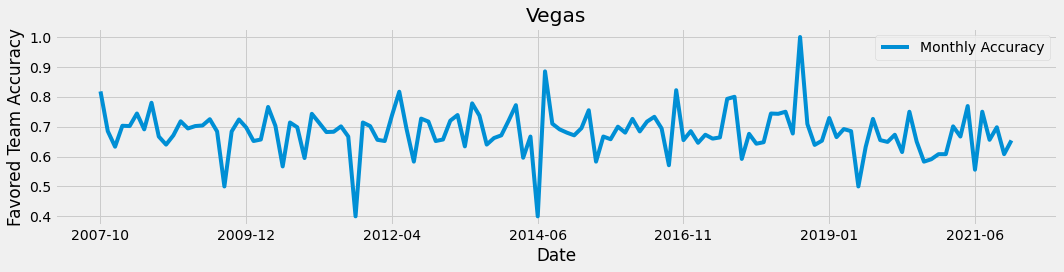

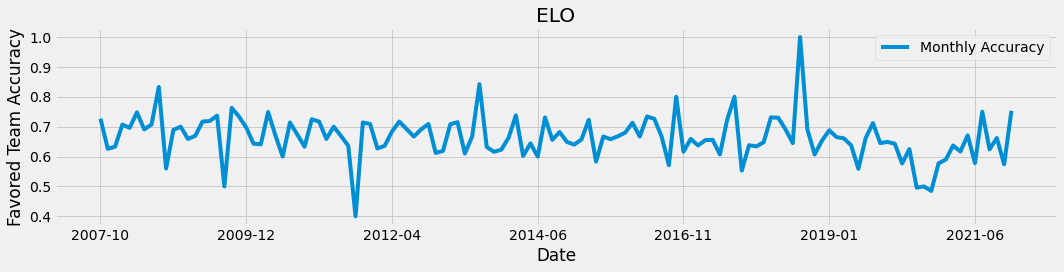

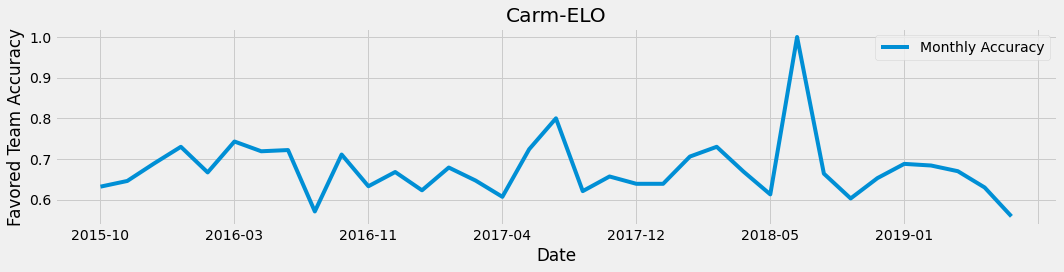

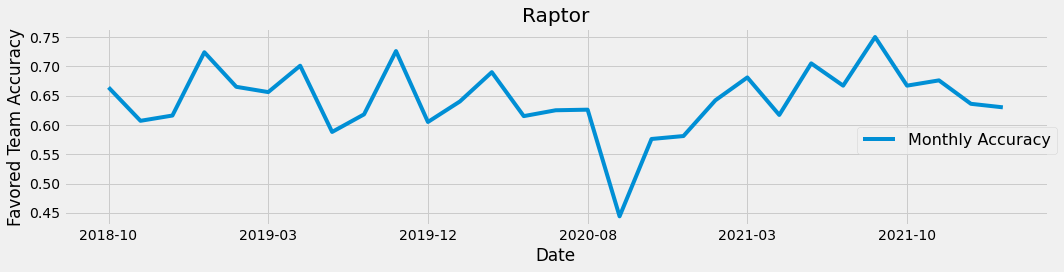

In [39]:
plt.rcParams.update({'figure.autolayout': True})
vegas_ave.plot(xlabel='Date', ylabel='Favored Team Accuracy', title= 'Vegas', figsize=(15,4))
elo_ave.plot(xlabel='Date', ylabel='Favored Team Accuracy', title= 'ELO', figsize=(15,4))
carmelo_ave.plot(xlabel='Date', ylabel='Favored Team Accuracy', title= 'Carm-ELO', figsize=(15,4))
raptor_ave.plot(xlabel='Date', ylabel='Favored Team Accuracy', title= 'Raptor', figsize=(15,4))
plt.legend(fontsize=16, bbox_to_anchor=(1.01, .5), borderaxespad=0)

This is interesting... Since both ELO and Vegas data cover the same range, let's overlay the two to identify where they diverge. Then we'll create one final overlay containing all datasets for the 2019 season, which is the only season in which 538 used each algorithm. Keep in mind, the Covid 19 outbreak also started in early 2020. 

Here you can also see that all predictors did terribly in June, 2019 (the Finals). All except for the raptor (20%) had 0% accuracy in picking the favorite. For the next part, we are going to add those games to the previous month to reduce the squew of the overall mean, std, and range. 

In [12]:
# run this code then rerun the functions above
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.strftime("%Y-%m")
df['date'][df['date']=='2019-06']='2019-05'

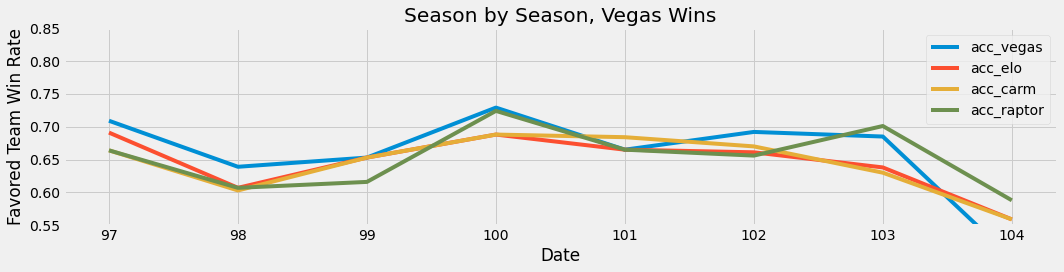

In [17]:
plt.rcParams.update({'figure.autolayout': True})
combined_ave.plot(xlabel='Date', ylabel='Favored Team Win Rate', title= 'Season by Season, Vegas Wins', ylim = (.55, .85), figsize=(15,4))
plt.legend(loc = 'upper right')

In [18]:
combined_ave = combined_ave.reset_index().dropna()
combined_ave

,date,acc_vegas,acc_elo,acc_carm,acc_raptor
97,2018-10,0.709,0.691,0.664,0.664
98,2018-11,0.639,0.607,0.603,0.607
99,2018-12,0.653,0.653,0.653,0.616
100,2019-01,0.729,0.688,0.688,0.724
101,2019-02,0.665,0.665,0.684,0.665
102,2019-03,0.692,0.661,0.670,0.656
103,2019-04,0.685,0.638,0.630,0.701
104,2019-05,0.500,0.559,0.559,0.588


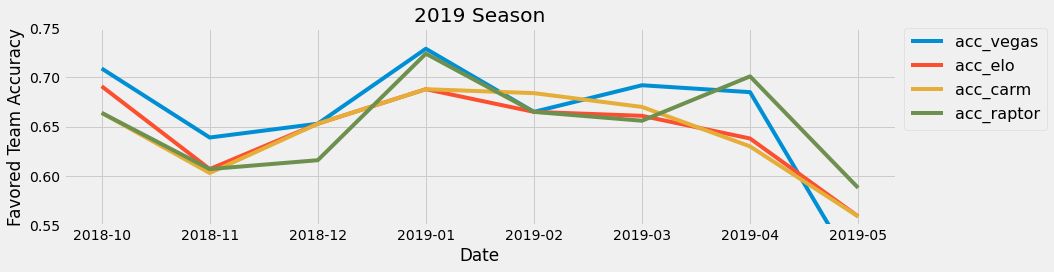

In [19]:
plt.rcParams.update({'figure.autolayout': True})
combined_ave_2019.plot(xlabel='Date', ylabel='Favored Team Accuracy', ylim = (.55, .75), title= '2019 Season', figsize=(15,4))
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)

In [20]:
combined_ave_2019.tail()

,acc_vegas,acc_elo,acc_carm,acc_raptor
date,,,,
2019-01,0.729,0.688,0.688,0.724
2019-02,0.665,0.665,0.684,0.665
2019-03,0.692,0.661,0.670,0.656
2019-04,0.685,0.638,0.630,0.701
2019-05,0.500,0.559,0.559,0.588


In [21]:
df[df['season']==2019].tail(6)

,date,season,neutral,playoff,home_team,away_team,home_elo_prob,away_elo_prob,home_carm-elo_prob,away_carm-elo_prob,...,win_10,elo_fav,home_elo_kelly,away_elo_kelly,carm-elo_fav,home_carm-elo_kelly,away_carm-elo_kelly,raptor_fav,home_raptor_kelly,away_raptor_kelly
15490,2019-05,2019,0,f,TOR,GSW,0.617375,0.382625,0.627282,0.372718,...,1.0,home,0.100832,-0.154224,home,0.124113,-0.172745,home,0.333447,-0.339282
15491,2019-05,2019,0,f,TOR,GSW,0.636183,0.363817,0.628686,0.371314,...,0.0,home,0.137753,-0.179929,home,0.119987,-0.166025,home,0.284180,-0.294519
15492,2019-05,2019,0,f,GSW,TOR,0.669124,0.330876,0.658841,0.341159,...,0.0,home,0.225751,-0.256075,home,0.201688,-0.236772,away,-0.192982,0.079840
15493,2019-05,2019,0,f,GSW,TOR,0.618826,0.381174,0.608075,0.391925,...,0.0,home,-0.269311,0.062192,home,-0.305111,0.078485,home,-0.408658,0.125608
15494,2019-05,2019,0,f,TOR,GSW,0.701389,0.298611,0.695165,0.304835,...,0.0,home,0.363959,-0.451876,home,0.350701,-0.438991,home,0.111863,-0.206881
15495,2019-05,2019,0,f,GSW,TOR,0.591806,0.408194,0.580399,0.419601,...,0.0,home,0.004007,-0.069069,home,-0.023827,-0.048462,home,-0.071398,-0.013243


In [22]:
def calc_mean(df,column, name):
    mean = str(round(df[column].mean(), 2))
    return print('name' + ' = ' + mean)


In [23]:
combined_raptor_ave.head(1)

,acc_vegas,acc_elo,acc_carm,acc_raptor
date,,,,
2018-10,0.709,0.691,0.664,0.664


In [24]:
raptor_vegas = combined_raptor_ave[['acc_vegas','acc_raptor']].reset_index()
raptor_vegas['date'] = pd.to_datetime(raptor_vegas['date']).dt.strftime("%Y-%m")
raptor_vegas.head()

,date,acc_vegas,acc_raptor
0,2018-10,0.709,0.664
1,2018-11,0.639,0.607
2,2018-12,0.653,0.616
3,2019-01,0.729,0.724
4,2019-02,0.665,0.665


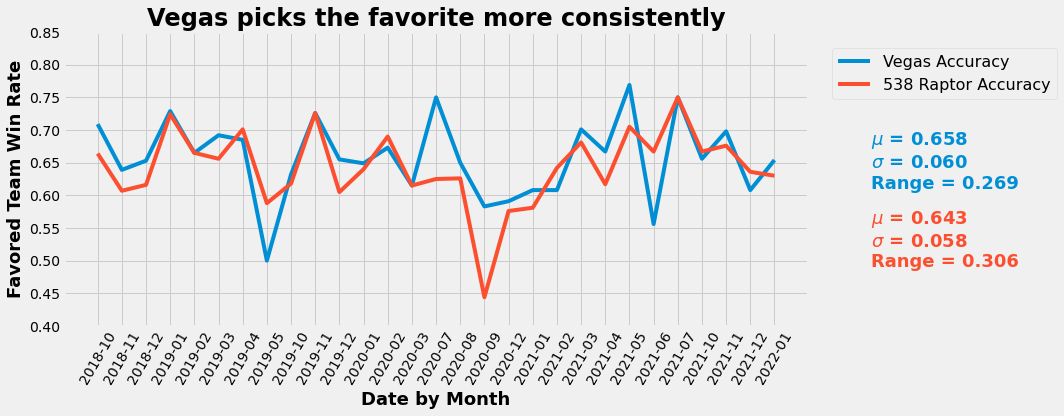

In [38]:
x = raptor_vegas['date']
# x = np.asarray(x, dtype='datetime64[s]')
y1 = raptor_vegas['acc_vegas']
y2 = raptor_vegas['acc_raptor']
fig, ax = plt.subplots(figsize=(15,6))
p = []
p += plt.plot(x, y1, label='Vegas Accuracy')
p += plt.plot(x, y2, label='538 Raptor Accuracy')

# ax.plot(x, y1, label='Vegas Accuracy')
# ax.plot(x, y2, label='538 Raptor Accuracy')

# raptor_vegas.plot(xlabel='Date by Month', ylabel='Favored Team Win Rate', ylim = (.45, .85), title= 'Raptor', figsize=(12,10))

plt.text(32, .61, '$\mu$ = {0:.3f}\n$\sigma$ = {1:.3f}\nRange = {2:.3f}'
        .format(np.mean(y1), np.std(y1), np.ptp(y1)),
         fontsize=18, fontweight='bold', color=p[0].get_color())
plt.text(32, .49, '$\mu$ = {0:.3f}\n$\sigma$ = {1:.3f}\nRange = {2:.3f}'
        .format(np.mean(y2), np.std(y2), np.ptp(y2)),
         fontsize=18, fontweight='bold', color=p[1].get_color())
ax.set_ylim(.4, .85)
ax.set_xlabel('Date by Month', fontsize=18, fontweight='bold')
ax.set_ylabel('Favored Team Win Rate', fontsize=18, fontweight='bold')
ax.set_title('Vegas picks the favorite more consistently', fontsize=24, fontweight='bold')
plt.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=1)
plt.xticks(rotation=60)
# format_538(fig, 'fivethirtyeight & sportsbookreviewsonline.com', xlabel=xlabel, ylabel=ylabel, title = title,
#            xoff=(0, 0), toff=(-.01, 1.1), soff=(-2, 12.05), suffix='%', suffix_offset=0
plt.show()

# print('vegas = ' + str(round(combined_raptor_ave['acc_vegas'].mean(), 2)) + ',',
#       'raptor = ' + str(round(combined_raptor_ave['acc_raptor'].mean(), 2)) + ',', 
#       'elo = ' + str(round(combined_raptor_ave['acc_elo'].mean(), 2)))

# format_538(fig, 'NBA Stats & Covers.com', xlabel=xlabel, ylabel=ylabel, title=title, subtitle=subtitle,
#            xoff=(-0.09, 1.01), toff=(-0.082, 1.16), soff=(-0.082, 1.05), suffix='%', suffix_offset=3)

In [ ]:
vegas_low_acc = vegas_ave[vegas_ave['win_10']<60]
vegas_low_acc.plot(kind="bar",xlabel = 'Month', ylabel='Amount', title= 'Accuracy Below 60%')

In [ ]:
vegas_df['date'] = pd.to_datetime(vegas_df['date'],format='%Y-%m-%d')
vegas_df.set_index('date',inplace=True)
vegas_df.resample('M').season.mean().head()
# # vegas_low_acc['date'] = vegas_low_acc['date'].astype()
# vegas_low_acc['date'] = pd.to_datetime(vegas_low_acc['date'],format='%Y-%m-%d')
# vegas_low_acc['date'].groupby(vegas_low_acc["date"].dt.month).count().plot(kind="bar",xlabel = 'Month', ylabel='Amount', title= 'Total # of Games per Month')

In [ ]:
elo_df = df[['date','season','elo_fav','winning_team']]

elo_df.loc[elo_df['elo_fav']==elo_df['winning_team'], 'win 10'] = '1'
elo_df.loc[elo_df['elo_fav']!=elo_df['winning_team'], 'win 10'] = '0'

elo_df['cumulative_percent'] = elo_df['win 10'].expanding().sum()/elo_df['win 10'].expanding().count()

elo_df = elo_df.dropna()

elo_df.plot(x='date', y='cumulative_percent')

In [ ]:
# carmelo_df = df[['date','season','carmelo_fav','winning_team']]

# carmelo_df.loc[carmelo_df['carmelo_fav']==carmelo_df['winning_team'], 'win 10'] = '1'
# carmelo_df.loc[carmelo_df['carmelo_fav']!=carmelo_df['winning_team'], 'win 10'] = '0'

# carmelo_df = carmelo_df.dropna()

# carmelo_df['cumulative_percent'] = carmelo_df['win 10'].expanding().sum()/carmelo_df['win 10'].expanding().count()

# transform_data(df,'elo').plot(x='date', y='accuracy_percent')

In [ ]:
raptor_df = df[['date','season','raptor_fav','winning_team']]

raptor_df.loc[raptor_df['raptor_fav']==raptor_df['winning_team'], 'win 10'] = '1'
raptor_df.loc[raptor_df['raptor_fav']!=raptor_df['winning_team'], 'win 10'] = '0'

raptor_df = raptor_df.dropna()

raptor_df['cumulative_percent'] = raptor_df['win 10'].expanding().sum()/raptor_df['win 10'].expanding().count()

raptor_df.plot(x='date', y='cumulative_percent')

In [ ]:
def profit(df, predict, winner):

In [ ]:

# copy to new cell. Simulate cumulative profit.
vegas_df = df[['date','season','vegas_fav','winning_team']]

vegas_df.loc[vegas_df['vegas_fav']==vegas_df['winning_team'], 'win 10'] = '1'
vegas_df.loc[vegas_df['vegas_fav']!=vegas_df['winning_team'], 'win 10'] = '0'

## Calculating the Kelly Criterion

At the start of this section, I am going to add columns neccessary to calculate the [kelly criterion][https://en.wikipedia.org/wiki/Kelly_criterion]. The kelly criterion formula is k% = (bp-q)/b where:
- k% is the optimal percentange of the bankroll to wager.
- p is the probability of a win.
- q is the probability of a loss (q=1-p).
- b is the proportion of the bet gained with a win. E.g. If betting \\$10 on a 2-to-1 odds bet, (upon win you are returned \\$30, winning you \\$20), then b=\\$20/\\$10=2.
[https://en.wikipedia.org/wiki/Kelly_criterion]:https://en.wikipedia.org/wiki/Kelly_criterion

In [ ]:
# calculate moneyline data as probability of winning (vegas odds). Useful for checking if numbers make sense. 
df.loc[df['home_ml'] < 0, 'home_ml_prob'] = (df["home_ml"]*-1)/(df["home_ml"]*-1+100)
df.loc[df['home_ml'] > 0, 'home_ml_prob'] = 100/(df["home_ml"]+100)

df.loc[df['away_ml'] < 0, 'away_ml_prob'] = (df["away_ml"]*-1)/(df["away_ml"]*-1+100)
df.loc[df['away_ml'] > 0, 'away_ml_prob'] = 100/(df["away_ml"]+100)

df.head()

In [ ]:
df = df[df["playoff"].notnull()]

In [ ]:
df

In [ ]:
# calculate proportion of the bet gained with a win
df.loc[df['home_ml'] > 0, 'home_b'] = df["home_ml"]/100
df.loc[df['home_ml'] < 0, 'home_b'] = -100/df["home_ml"]
df.loc[df['away_ml'] > 0, 'away_b'] = df["away_ml"]/100
df.loc[df['away_ml'] < 0, 'away_b'] = -100/df["away_ml"]
df.head()

In [ ]:
# calculate the kelly criterion for each probability column
# Remember:
# carm-elo_prob starts at 2016 season and ends after the 2019 season
# raptor_prob starts at 2019 season and but the formula switches after the 2020 season 

df["home_elokelly"] =(df["home_b"]*df["home_elo_prob"]-(1-df["home_elo_prob"]))/df["home_b"]
df["away_elokelly"] =((df["away_b"]*df["away_elo_prob"])-(1-df["away_elo_prob"]))/df["away_b"]

df["home_carmelokelly"] =((df["home_b"]*df["home_carm-elo_prob"])-(1-df["home_carm-elo_prob"]))/df["home_b"]
df["away_carmelokelly"] =((df["away_b"]*df["away_carm-elo_prob"])-(1-df["away_carm-elo_prob"]))/df["away_b"]

df["home_raptorkelly"] =((df["home_b"]*df["home_raptor_prob"])-(1-df["home_raptor_prob"]))/df["home_b"]
df["away_raptorkelly"] =((df["away_b"]*df["away_raptor_prob"])-(1-df["away_raptor_prob"]))/df["away_b"]
df.head()

In [ ]:
# determine which team is favored by the kelly criterion (useful for later calculations)
df.loc[df['home_elokelly'] > df["away_elokelly"], 'elo_kfav'] = "Home"
df.loc[df['home_elokelly'] < df["away_elokelly"], 'elo_kfav'] = "Away"
df.loc[df['home_carmelokelly'] > df["away_carmelokelly"], 'carmelo_kfav'] = "Home"
df.loc[df['home_carmelokelly'] < df["away_carmelokelly"], 'carmelo_kfav'] = "Away"
df.loc[df['home_raptorkelly'] > df["away_raptorkelly"], 'rapt_kfav'] = "Home"
df.loc[df['home_raptorkelly'] < df["away_raptorkelly"], 'rapt_kfav'] = "Away"

In [ ]:
# determine which team won
df.loc[df['home_score'] > df["away_score"], 'Team W/L'] = "Home"
df.loc[df['home_score'] < df["away_score"], 'Team W/L'] = "Away"
df.head()

In [ ]:
# see if the kelly favored team won or lost
df.loc[df['elo_kfav'] == df["Team W/L"] , 'elo_accuracy'] = "True"
df.loc[df['elo_kfav'] != df["Team W/L"], 'elo_accuracy'] = "False"
df.loc[df['carmelo_kfav'] == df["Team W/L"] , 'carmelo_accuracy'] = "True"
df.loc[df['carmelo_kfav'] != df["Team W/L"], 'carmelo_accuracy'] = "False"
df.loc[df['rapt_kfav'] == df["Team W/L"] , 'rapt_accuracy'] = "True"
df.loc[df['rapt_kfav'] != df["Team W/L"], 'rapt_accuracy'] = "False"
df.head()

In [ ]:
# returns the percentage of correct bets, regardless of whether the kelly criterion was negative
elo_kelly = df['elo_accuracy'][df['elo_accuracy']=='True'].count()/df['elo_accuracy'].count()
carmelo_kelly = df['carmelo_accuracy'][(df['carmelo_accuracy']=='True') & (df['season'] > 2015) & (df['season'] < 2020)].count()/df['carmelo_accuracy'][(df['season']>2015) & (df['season'] < 2020)].count()
rapt_kelly = df['rapt_accuracy'][(df['rapt_accuracy']=='True') & (df['season']>2018)].count()/df['rapt_accuracy'][df['season']>2018].count()
print(elo_kelly,carmelo_kelly,rapt_kelly)

# returns the percentage of correct bets where the kelly criterion was positive
elo_kelly_bets = df['elo_accuracy'][(df['elo_accuracy']=='True') & ((df['home_elokelly'] > 0) | (df['away_elokelly'] > 0))].count()/df['elo_accuracy'].count()
carmelo_kelly_bets = df['carmelo_accuracy'][((df['carmelo_accuracy']=='True') & (df['season']>2015) & (df['season'] < 2020)) & ((df['home_carmelokelly'] > 0) | (df['away_carmelokelly'] > 0))].count()/df['carmelo_accuracy'][(df['season']>2015) & (df['season'] < 2020)].count()
rapt_kelly_bets = df['rapt_accuracy'][((df['rapt_accuracy']=='True') & (df['season']>2018)) & ((df['home_raptorkelly'] > 0) | (df['away_raptorkelly'] > 0))].count()/df['rapt_accuracy'][df['season']>2018].count()
print(elo_kelly_bets,carmelo_kelly_bets,rapt_kelly_bets)

# raptor was changed after the 2019-2020 season. Let's see if it's any different.
# carmelo was discontinued after the 2019 season.
elo_kelly_2020 = df['elo_accuracy'][(df['elo_accuracy']=='True') & (df['season'] > 2020) & ((df['home_elokelly'] > 0) | (df['away_elokelly'] > 0))].count()/df['elo_accuracy'][df['season'] > 2020].count()
carmelo_kelly_2020 = 'discontinued'
rapt_kelly_2020 = df['rapt_accuracy'][((df['rapt_accuracy']=='True') & (df['season']>2020)) & ((df['home_raptorkelly'] > 0) | (df['away_raptorkelly'] > 0))].count()/df['rapt_accuracy'][df['season']>2020].count()
print(elo_kelly_2020,carmelo_kelly_2020,rapt_kelly_2020)


# Oof... not so good
At best, our kelly criterion bets would have won 42.7% of the time using the updated RAPTOR probability.
## Still... would our bets have made money?
Let's calculate it out for the 2021 season up until now to find out.

In [ ]:
raptor_2021_up = df[(df['season']>2020) & ((df['home_raptorkelly'] > 0) | (df['away_raptorkelly'] > 0))]
raptor_2021_up.to_csv('raptor_2021_up.csv')
elo_2021_up = df[(df['season']>2020) & ((df['home_elokelly'] > 0) | (df['away_elokelly'] > 0))]
elo_2021_up.to_csv('elo_2021_up.csv')

In [ ]:
# df.loc[df['home_elokelly'] > 0, 'elo_bet_pct'] = "home_elokelly"
# df.loc[df['home_elokelly'] < 0], 'elo_bet_pct'] = pd.nan
# df.loc[df['home_carmelokelly'] > df["away_carmelokelly"], 'carmelo_kfav'] = "Home"
# df.loc[df['home_carmelokelly'] < df["away_carmelokelly"], 'carmelo_kfav'] = "Away"
# df.loc[df['home_raptorkelly'] > df["away_raptorkelly"], 'rapt_kfav'] = "Home"
# df.loc[df['home_raptorkelly'] < df["away_raptorkelly"], 'rapt_kfav'] = "Away"